In [1]:
import anndata
import networkx as nx
import scanpy as sc
import scglue
from matplotlib import rcParams
import numpy as np
import scipy as sp
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

### Pre-processing

In [3]:
rna = anndata.read_h5ad("../data/Multiome_GEX.s4d1.h5ad")
rna

AnnData object with n_obs × n_vars = 7235 × 13431
    obs: 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'cell_type', 'pseudotime_order_GEX', 'batch', 'pseudotime_order_ATAC', 'is_train'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'dataset_id', 'organism'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [4]:
atac = anndata.read_h5ad("../data/Multiome_ATAC.peak.s3d7.h5ad")
atac

AnnData object with n_obs × n_vars = 6094 × 116490
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'cell_type', 'pseudotime_order_ATAC', 'batch', 'pseudotime_order_GEX', 'is_train'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism', 'sample_pm_varnames'
    obsm: 'gene_activity', 'lsi_full', 'lsi_red', 'umap'
    layers: 'counts'

In [5]:
rna.layers['raw'] = rna.layers['counts'].copy()
rna.X = rna.layers['counts'].copy()

In [6]:
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")


In [7]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

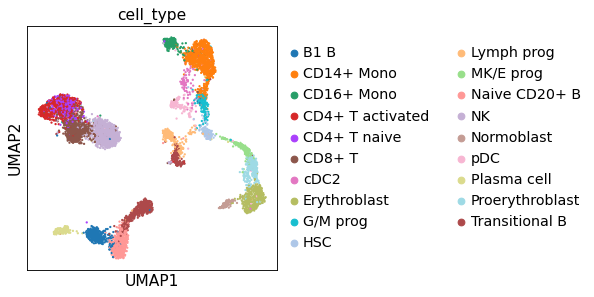

In [8]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.pl.umap(rna, color="cell_type")

In [9]:
atac.X = atac.layers['counts'].copy()

In [10]:
#sc.pp.highly_variable_genes(atac, n_top_genes=30000, flavor="seurat_v3")
scglue.data.lsi(atac, n_components=100, n_iter=15)

/home/chaozhong/.local/lib/python3.6/site-packages/scglue/num.py:213: RuntimeWarning: divide by zero encountered in true_divide
  idf = X.shape[0] / X.sum(axis=0)


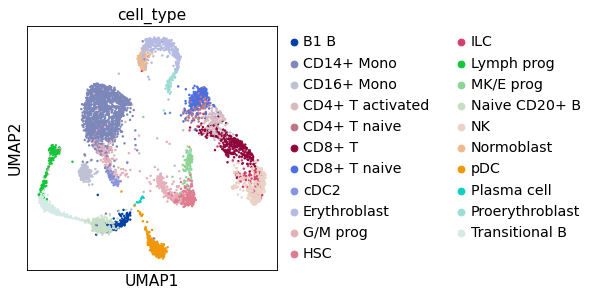

In [11]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)
sc.pl.umap(atac, color="cell_type")

### Construct graph

In [12]:
scglue.data.get_gene_annotation(
    rna, gtf="../../../biolib/Homo_sapiens.GRCh38.104.gtf",
    gtf_by="gene_id",
    var_by="gene_ids",
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,chrom,chromStart,chromEnd
AL627309.5,1,141473.0,173862.0
LINC01409,1,778746.0,810065.0
LINC01128,1,825137.0,859446.0
NOC2L,1,944202.0,959309.0
KLHL17,1,960583.0,965719.0


In [13]:
rna.X = sp.sparse.csr_matrix(rna.X)
rna = rna[:,~rna.var['chromStart'].isna()]

In [14]:
rna.X = rna.X.toarray().copy()

In [15]:
split = atac.var_names.str.split(r"[-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chrom"] = atac.var["chrom"].str.split('hr').str[1]
atac.var["chromStart"] = split.map(lambda x: x[1])
atac.var["chromEnd"] = split.map(lambda x: x[2])
atac.var.head()

,feature_types,chrom,chromStart,chromEnd
chr1-9776-10668,ATAC,1,9776,10668
chr1-180726-181005,ATAC,1,180726,181005
chr1-181117-181803,ATAC,1,181117,181803
chr1-191133-192055,ATAC,1,191133,192055
chr1-267562-268456,ATAC,1,267562,268456


In [16]:
graph = scglue.genomics.rna_anchored_prior_graph(rna, atac)
graph

In [17]:
graph.number_of_nodes(), graph.number_of_edges()

(129908, 282088)

In [18]:
# Graph node covers all omic features
all(graph.has_node(gene) for gene in rna.var_names), \
all(graph.has_node(peak) for peak in atac.var_names)

(True, True)

In [19]:
# Edge attributes contain weights and signs
for _, e in zip(range(5), graph.edges):
    print(f"{e}: {graph.edges[e]}")

('LINC01409', 'chr1-778276-779191', 0): {'dist': 0, 'weight': 1.0, 'sign': 1}
('LINC01409', 'LINC01409', 0): {'weight': 1.0, 'sign': 1}
('chr1-778276-779191', 'LINC01409', 0): {'dist': 0, 'weight': 1.0, 'sign': 1}
('chr1-778276-779191', 'chr1-778276-779191', 0): {'weight': 1.0, 'sign': 1}
('LINC01128', 'chr1-822804-823597', 0): {'dist': 0, 'weight': 1.0, 'sign': 1}


In [20]:
# Each node has a self-loop
all(graph.has_edge(gene, gene) for gene in rna.var_names), \
all(graph.has_edge(peak, peak) for peak in atac.var_names)

(True, True)

In [21]:
# Graph is symmetric
all(graph.has_edge(j, i) for i, j, _ in graph.edges)

True

In [22]:
atac.var.head()

,feature_types,chrom,chromStart,chromEnd,highly_variable
chr1-9776-10668,ATAC,1,9776,10668,False
chr1-180726-181005,ATAC,1,180726,181005,False
chr1-181117-181803,ATAC,1,181117,181803,False
chr1-191133-192055,ATAC,1,191133,192055,False
chr1-267562-268456,ATAC,1,267562,268456,False


In [23]:
rna.write("rna_preprocessed.h5ad", compression="gzip")
atac.write("atac_preprocessed.h5ad", compression="gzip")
nx.write_graphml(graph, "prior.graphml.gz")

/mnt/hdd/chaozhong/pylib/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.var` of view, copying.
... storing 'chrom' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'score' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'strand' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'thickStart' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'thickEnd' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'itemRgb' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'blockCount' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'blockSizes' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'blockStarts' as categorical
Trying to set attribute `.v